# ARIMA model in Python

Here we follow the Jason's blog: [How to Create an ARIMA Model for Time Series Forecasting with Python](https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/), to implement [ARIMA model](http://www.statsmodels.org/dev/generated/statsmodels.tsa.arima_model.ARIMA.html) to forecast time series data. The (p,d,q) **ARIMA (AR-I-MA)** model is written as

$$y_t = c + \phi_1 y^{'}_{t-1} + \phi_2 y^{'}_{t-2}.. + \phi_p y^{'}_{t-p} + \theta_1 e_{t-1} + .. + \theta_q e_{t-q} + e_t $$

**AR**: Autoregression. A model that uses the **dependent** relationship between an observation and some number of **lagged** (past) observations. In other words, it descibes
$$y_t = c + \phi_1 y_{t-1} + \phi_2 y_{t-2}.. + \phi_p y_{t-p} + e_t,$$

where $y_{t-1}, y_{t-2} \cdots$ are lagged (past) observations of $y_t$, $t-1, t-2, \cdots < t$ and $e_t$ is white noise, which is ideally normal distributed and has zero mean and variance one. This part is analgous to a multiple regression model, but using past observations as predictors, named **AR(p) model**.

**I**: Integrated. The use of differencing of raw observations (e.g. subtracting an observation from an observation at the previous time step) in order to make the time series **stationary**. Here **integration** means the reverse of differencing. It turns $y_t \to y^{'}_t = y_{t}-y_{t-1}$, meaning the differenced series (may have been differenced more than once).

**MA**: Moving Average. A model that uses the dependency between an observation and a **residual error** from a moving average model applied to lagged observations, we refer to **MA(q) model**, reads as 
$$y_t = c + e_t + \theta_1 e_{t-1} + .. + \theta_q e_{t-q}.$$

Each value of $y_t$ can be thought of as a weighted moving average of the past $q$ errors.

The choice of the order hyperparameters (p,d,q) is difficult to determine. We have also followed up Jason's another blog: [How to Grid Search ARIMA Model Hyperparameters with Python](https://machinelearningmastery.com/grid-search-arima-hyperparameters-with-python/) to grid search the parameters.

## ARIMA(p,d,q)

**p**: The number of lag observations included in the model, also called the lag order.

**d**: The number of times that the raw observations are differenced, also called the degree of differencing.

**q**: The size of the moving average window, also called the order of moving average.

## Data Source

The units are a sales count and there are 36 observations. The original dataset is credited to Makridakis, Wheelwright, and Hyndman (1998). [Download here](https://datamarket.com/data/set/22r0/sales-of-shampoo-over-a-three-year-period#!ds=22r0&display=line)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pylab
from pylab import *
import sys

sys.path.append("/Users/hhhung/anaconda/lib/python3.4/site-packages/")

In [3]:
data = pd.read_csv('sales-of-shampoo-over-a-three-ye.csv')

In [4]:
data.head()

,Month,Sales of shampoo over a three year period
0,1-Jan,266.0
1,2-Jan,145.9
2,3-Jan,183.1
3,4-Jan,119.3
4,5-Jan,180.3


In [5]:
data.shape

(36, 2)

In [6]:
import datetime as dtte
start = dtte.datetime.strptime("1-Jan-1998", "%d-%b-%Y")
daterange = pd.date_range(start, periods=36,freq='1M')

In [7]:
daterange[:5]

DatetimeIndex(['1998-01-31', '1998-02-28', '1998-03-31', '1998-04-30',
               '1998-05-31'],
              dtype='datetime64[ns]', freq='M')

The data source came from 1998. So I assume the start-date is 1998.

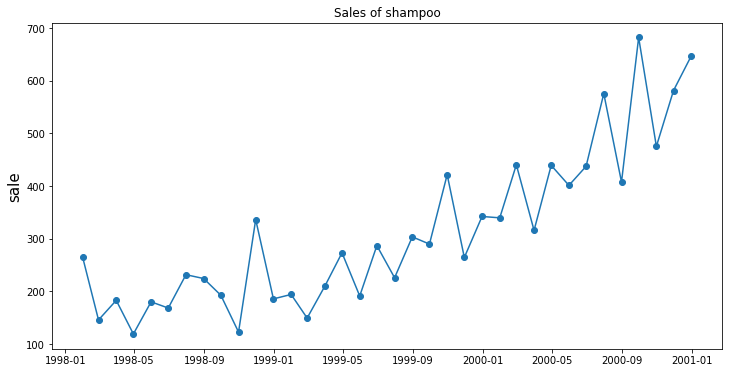

In [8]:
plt.figure(figsize=(12,6))
plt.plot(daterange, data['Sales of shampoo over a three year period'], 'o-')
plt.title('Sales of shampoo')
plt.ylabel('sale', fontsize=15)
plt.show()

Shampoo Sales data shows a clear increasing trend.

This suggests that the time series is **not stationary** and will require differencing to make it stationary, at least a difference order of 1. A linear regression model is constructed including the specified number and type of terms, and the data is prepared by a degree of differencing in order to make it stationary, i.e. to remove trend and seasonal structures that negatively affect the regression model.

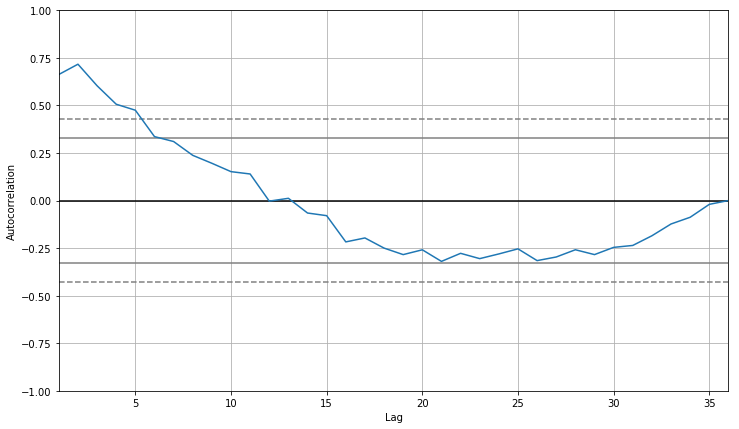

In [9]:
from pandas.tools.plotting import autocorrelation_plot
plt.figure(figsize=(12,7))
autocorrelation_plot(data['Sales of shampoo over a three year period'])
plt.show()

In the above, we see the autocorrelation drops below the threshold (indicated by dash lines) after 5 lag. Since we can first try p=5 in the ARIMA model (or AR model).

## Training the ARIMA model

As a concrete example, here we implement $(p,d,q)=(5,1,0)$ to train the ARIMA model

In [10]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(data['Sales of shampoo over a three year period'].tolist(), order=(5,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

/Users/hhhung/anaconda/envs/tensorflow/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.4 of module 'statsmodels.tsa.kalmanf.kalman_loglike' does not match runtime version 3.5
  return f(*args, **kwds)
/Users/hhhung/anaconda/envs/tensorflow/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: builtins.type size changed, may indicate binary incompatibility
  return f(*args, **kwds)


                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   35
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -196.170
Method:                       css-mle   S.D. of innovations             64.241
Date:                Wed, 11 Apr 2018   AIC                            406.340
Time:                        01:35:48   BIC                            417.227
Sample:                             1   HQIC                           410.098
                                                                              
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         12.0649      3.652      3.304      0.003         4.908    19.222
ar.L1.D.y     -1.1082      0.183     -6.063      0.000        -1.466    -0.750
ar.L2.D.y     -0.6203      0.282     -2.203      0.0

In [11]:
model_fit.resid

array([-132.16491308,  -75.28258201,  -99.566808  ,  -40.8317874 ,
        -44.12405262,   47.97133592,   27.51612019,  -26.14208772,
       -133.29664307,   86.06521454,  -14.9849387 ,  -91.45203115,
        -93.77306211,  -39.61256709,   21.97802186,   -7.18671795,
         21.98041587,   -6.93370806,    2.64497282,   13.30302108,
        127.95958605,  -48.85610866,  -39.18450092,  -15.28613842,
         70.45786383,  -60.33746871,   39.72904775,   10.2532238 ,
          1.35798927,  133.23791357,  -11.89704343,  129.12980466,
         15.22559939,  -37.98094133,   77.74995924])

We can observe there exists slight increasing trend on the residuals

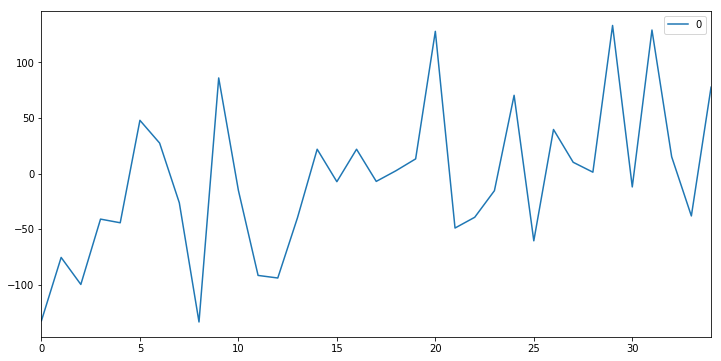

In [14]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot(figsize=(12,6))
plt.show()

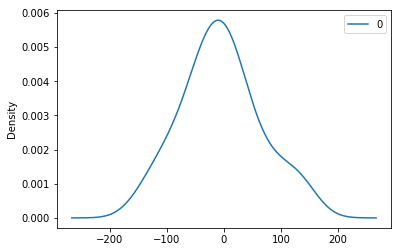

In [15]:
residuals.plot(kind='kde')
plt.show()

The distribution of the residual errors is displayed. The results show that indeed there is a bias in the prediction (a non-zero mean in the residuals).

In [16]:
print(residuals.describe())

                0
count   35.000000
mean    -5.495257
std     68.132879
min   -133.296643
25%    -42.477920
50%     -7.186718
75%     24.748268
max    133.237914


## Prediction and MSE

We use the first 66% data to train the ARIMA model, and predict observation at next time step, say $y_t$. For each later time $t+1$, we implement all historical data $y_1 \cdots y_t$ to train the model to predict $y_{t+1}$, $y_1 \cdots y_{t+1}$ to train the model and predict $y_{t+2}$... At each time, we can compare prediction $\hat{y}_t$ and actaul value $y_t$, and accumulate the entire mean-square-error for validation
$$\textrm{MSE}=\frac{1}{N}\sum_{t \in \textrm{test set}} (\hat{y}_t-y_t)^2$$

We continue select $(5,1,0)$ ARIMA model and compute the MSE

In [17]:
from sklearn.metrics import mean_squared_error
X = data['Sales of shampoo over a three year period'].tolist()
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

predicted=349.117744, expected=342.300000
predicted=306.512913, expected=339.700000
predicted=387.376410, expected=440.400000
predicted=348.154229, expected=315.900000
predicted=386.308815, expected=439.300000
predicted=356.082077, expected=401.300000
predicted=446.379468, expected=437.400000
predicted=394.737277, expected=575.500000
predicted=434.915511, expected=407.600000
predicted=507.923411, expected=682.000000
predicted=435.482994, expected=475.300000
predicted=652.743826, expected=581.300000
predicted=546.343547, expected=646.900000
Test MSE: 6958.325


Each predicted results at $t$ came from previous observations $t-1, t-2\cdots$ as predictors in the ARIMA models. In this example, we have 13 observations in the test dataset, so 13 predictions. The total MSE is 6958.

We can visualize the prediction and actual data

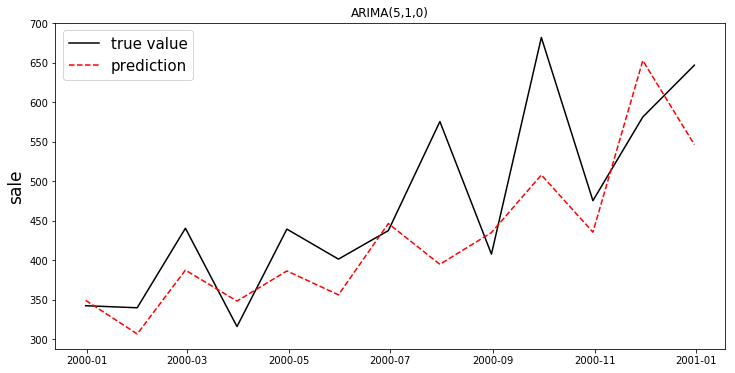

In [18]:
plt.figure(figsize=(12,6))
plt.plot(daterange[size:len(X)], test, color='k', label='true value')
plt.plot(daterange[size:len(X)], predictions, '--', color='red', label ='prediction')
plt.legend(loc='upper left', fontsize=15)
plt.title('ARIMA(5,1,0)')
plt.ylabel('sale', fontsize=17)
plt.show()

The classical approach for fitting an ARIMA model is to follow the Box-Jenkins Methodology. To fit the model efficiently on modest-sized time series datasets and better select $(p,d,q)$, grid search is required.

## Grid Search

For grid search, we use two metrics **MSE** and **Akaike's information Criterion (AIC)**. AIC reads as

$$\text{AIC} = -2\log(L)+2(p+q+k+1),$$

where $L$ is the likelihood; $k=1$ if $c\ne 0$ and $k=0$ if $c=0$.
Lower MSE and AIC indicates a better model fitting. Thus we iterate through the optimal hyperparameters (p,d,q) which gives minimum MSE and AIC.

In [19]:
def evaluate_ARIMA_mse(X, parameters):
    size = int(len(X) * 0.66)
    train, test = X[0:size], X[size:len(X)]
    history = [x for x in train]
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=parameters)
        model_fit = model.fit(disp=0)
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)
    error = mean_squared_error(test, predictions)
    return error, model_fit.aic

There are two additional considerations for grid searching. The first is to ensure the input data are floating point values (as opposed to integers or strings), as this can cause the ARIMA procedure to fail.

Second, the statsmodels ARIMA procedure internally uses numerical optimization procedures to find a set of coefficients for the model. These procedures can fail, which in turn can throw an exception. We must catch these exceptions and skip those configurations that cause a problem. This happens more often then you would think.

For the above case, we use **try and except** in Python to avoid errors to stop grid search.

In [20]:
min_mse, min_aic, best_pdq = float('inf'), float('inf'), None
for p in range(6):
    for d in range(3):
        for q in range(3):
            try:
                mse, aic = evaluate_ARIMA_mse(X, (p,d,q))
                print ((p, d, q), mse, aic)
                if mse < min_mse:
                    min_mse, min_aic, best_pdq = mse, aic, (p,d,q)
            except:
                continue

(0, 0, 0) 52425.268134 447.964107496
(0, 0, 1) 38145.2376367 441.9829028585866
(0, 0, 2) 23989.5374743 426.84505798173166
(0, 1, 0) 18003.17303 419.403160018
(0, 1, 1) 9558.34916458 397.08703455988865
(0, 2, 0) 67339.8103144 448.645122735
(0, 2, 1) 18321.8762635 413.24784777535245
(1, 0, 0) 23113.0750921 429.2852465708879
(1, 1, 0) 7121.37110167 392.51744484771666
(1, 1, 1) 7003.68458602 390.234826668207
(1, 2, 0) 18608.0315914 408.60889304019577


/Users/hhhung/anaconda/lib/python3.4/site-packages/statsmodels/tsa/tsatools.py:492: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/
/Users/hhhung/anaconda/lib/python3.4/site-packages/statsmodels/tsa/tsatools.py:493: RuntimeWarning: overflow encountered in exp
  (1+np.exp(-params))).copy()
/Users/hhhung/anaconda/lib/python3.4/site-packages/statsmodels/tsa/tsatools.py:493: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
/Users/hhhung/anaconda/lib/python3.4/site-packages/statsmodels/tsa/tsatools.py:494: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/
/Users/hhhung/anaconda/lib/python3.4/site-packages/statsmodels/tsa/tsatools.py:495: RuntimeWarning: overflow encountered in exp
  (1+np.exp(-params))).copy()
/Users/hhhung/anaconda/lib/python3.4/site-packages/statsmodels/tsa/tsatools.py:495: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()


(2, 1, 0) 5689.93017961 392.0375785632103
(2, 1, 1) 7759.70781231 392.2223593011542
(2, 2, 0) 9860.94634998 401.18151141693966


/Users/hhhung/anaconda/lib/python3.4/site-packages/statsmodels/tsa/tsatools.py:562: RuntimeWarning: divide by zero encountered in true_divide
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
/Users/hhhung/anaconda/lib/python3.4/site-packages/statsmodels/tsa/tsatools.py:536: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/hhhung/anaconda/lib/python3.4/site-packages/statsmodels/tsa/tsatools.py:537: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/hhhung/anaconda/lib/python3.4/site-packages/statsmodels/tools/numdiff.py:227: RuntimeWarning: invalid value encountered in add
  2./hess[i,j]
/Users/hhhung/anaconda/lib/python3.4/site-packages/statsmodels/tools/numdiff.py:227: RuntimeWarning: invalid value encountered in multiply
  2./hess[i,j]
/Users/hhhung/anaconda/lib/python3.4/site-packages/statsmodels/tsa/tsatools.py:560: RuntimeWarning: inval

(3, 1, 0) 6998.94119454 392.4262473319769
(3, 1, 1) 7145.87550255 393.68738470245114
(3, 2, 0) 10513.2857772 399.00502858429496


/Users/hhhung/anaconda/lib/python3.4/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/hhhung/anaconda/lib/python3.4/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/hhhung/anaconda/lib/python3.4/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(4, 1, 0) 6649.58905954 392.6119282882152
(4, 1, 1) 6796.31942624 394.3597775894604


/Users/hhhung/anaconda/lib/python3.4/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(4, 2, 0) 7596.3249904 392.514110446288
(4, 2, 1) 4694.8700222 383.00197582107506


/Users/hhhung/anaconda/lib/python3.4/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/hhhung/anaconda/lib/python3.4/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/hhhung/anaconda/lib/python3.4/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/hhhung/anaconda/lib/python3.4/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/hhhung/anaconda/lib/python3.4/site-packages/statsmodels/base/model.py:443: RuntimeWarning: Inverting hessian failed, no bse or cov_pa

(5, 1, 0) 6958.32490541 394.2726282359638


/Users/hhhung/anaconda/lib/python3.4/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/hhhung/anaconda/lib/python3.4/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/hhhung/anaconda/lib/python3.4/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/hhhung/anaconda/lib/python3.4/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/hhhung/anaconda/lib/python3.4/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed

(5, 2, 0) 6710.50330167 391.28477145367196


By grid searching p=0-6, d,q=0-3, the optimal hyperparameters is given by $(p,d,q)=(4,2,1)$

In [21]:
print (best_pdq, min_mse, min_aic)

(4, 2, 1) 4694.8700222 383.00197582107506


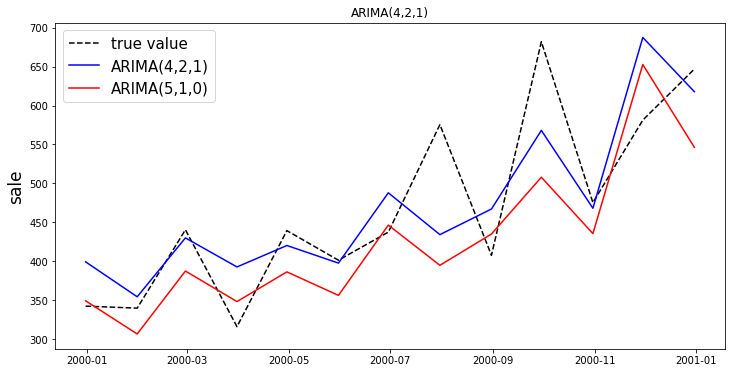

In [22]:
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions_421 = list()
for t in range(len(test)):
    model = ARIMA(history, order=(4,2,1))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions_421.append(yhat)
    obs = test[t]
    history.append(obs)


plt.figure(figsize=(12,6))
plt.plot(daterange[size:len(X)], test, '--', color='k', label='true value')
plt.plot(daterange[size:len(X)], predictions_421, color='blue', label ='ARIMA(4,2,1)')
plt.plot(daterange[size:len(X)], predictions, color='red', label ='ARIMA(5,1,0)')
plt.legend(loc='upper left', fontsize=15)
plt.title('ARIMA(4,2,1)')
plt.ylabel('sale', fontsize=17)
plt.show()

We can see $(4,2,1)$ slightly outperforms $(5,1,0)$ in the ARIMA model.

## Out-of-Sample Forecast

Not only compare the test data, next we further forecast the future result, followed by another [Jason's blog](https://machinelearningmastery.com/make-sample-forecasts-arima-python/)

In [24]:
model_fit = ARIMA(data['Sales of shampoo over a three year period'].tolist(), order=best_pdq).fit(disp=-1)
forecast_421 = model_fit.forecast(steps=5)

model_fit = ARIMA(data['Sales of shampoo over a three year period'].tolist(), order=(5,1,0)).fit(disp=-1)
forecast_510 = model_fit.forecast(steps=5)

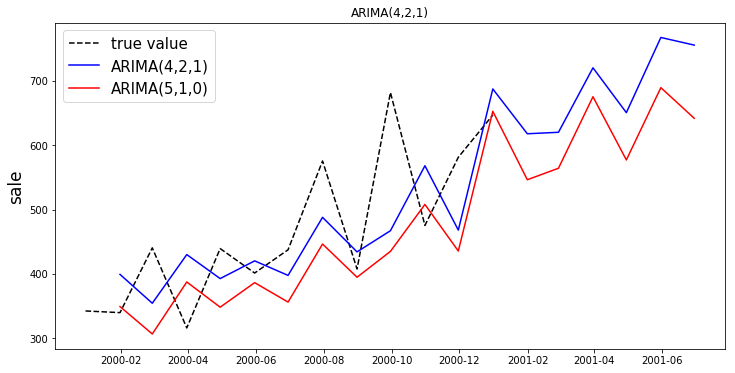

In [25]:
plt.figure(figsize=(12,6))

forecast_date = pd.date_range(dtte.datetime.strptime("1-Jan-2000", "%d-%b-%Y"), periods=18,freq='1M')

plt.plot(daterange[size:len(X)], test, '--', color='k', label='true value')
plt.plot(forecast_date, [x[0] for x in predictions_421]+list(forecast_421[0]), color='blue', label ='ARIMA(4,2,1)')
plt.plot(forecast_date, [x[0] for x in predictions]+list(forecast_510[0]), color='red', label ='ARIMA(5,1,0)')
plt.legend(loc='upper left', fontsize=15)
plt.title('ARIMA(4,2,1)')
plt.ylabel('sale', fontsize=17)
plt.show()

## Examine if Time Series Data is Staionay - Unit Root Tests

In the above, we simply implement the time series data on the ARIMA model. However, strictly speaking, the ARIMA model requires data to be stationary. **Stationary** means the data does **not** depend on the time at which is observed. For example, an increasing trend time series is obviously not stationary; since larger observation will correspond to later time. Seasonal time series data is also not stationary, since the values may implicitly tell us when it is. White noise is usually stationary.

If data is non-stationary, we can compute difference between consecutive observations, call **differencing**. One of ways to determine if data is stationary is to use a unit root test. The null hypothesis is 
$$ H_0: \textrm{Data is non-stationary}$$
and the alternative hypothesis is
$$ H_a: \textrm{Data is not non-stationary}$$

One of popular tests is the [Augmented Dickey-Fuller (ADF)](http://statsmodels.sourceforge.net/devel/generated/statsmodels.tsa.stattools.adfuller.html). If p-value > critical value, we cannot reject the null hypothesis; on the other hand, if p-value < critical value, we can reject the hypothesis, and we have statistically significant evidence to conclude that the data is stationary.

In [26]:
from statsmodels.tsa.stattools import adfuller

print('Results of Dickey-Fuller Test:')
dftest = adfuller(data['Sales of shampoo over a three year period'], autolag='AIC') 
## for testing stationarity, if yes, reject the hypothesis
# note negative counts, the ideal case of the value is minus infinity
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                  3.060142
p-value                         1.000000
#Lags Used                     10.000000
Number of Observations Used    25.000000
Critical Value (1%)            -3.723863
Critical Value (10%)           -2.632800
Critical Value (5%)            -2.986489
dtype: float64


In addition to the unit root test, the ACF plot also helps us judge if time series data is stationary. An ACF plot shows autocorrelations which measure the relation between $y_t$ and $y_{t-k}$ for different values of $k$. If it is stationary, it will drop to zero quickly (like an exponential decay), while non-stationary data decreases relatively slowly.

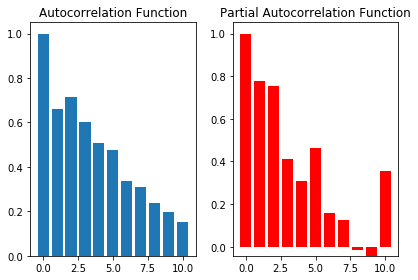

In [27]:
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(data['Sales of shampoo over a three year period'], nlags=10)
lag_pacf = pacf(data['Sales of shampoo over a three year period'], nlags=10, method='ols')

#Plot ACF: 
plt.subplot(121) 
plt.bar(np.arange(11), lag_acf)
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.bar(np.arange(11), lag_pacf, color = 'red')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

plt.show()

Here we see both ACF and PACF do not show exponential decay. This strongly hints the data is non-stationary. Strictly speaking, to implement the ARIMA model, we need to transform it until it becomes stationary.


## Transformation Data to Make Stationary - logarithm + moving average smoothing

The transformation includes logarithm or differencing. Logarithm can help stabilize the variance of a time series. Differencing or smoothing data with moving average helps to eliminate trend and seasonality. 

For the shampoo data, I have tried first and second-order differencing, but still fails to make the time series staionary. In the following, I instead follow the procedures suggested by other [blog discussion](https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/). We first take logarithm on the time series data, and then compute the moving average about 5 lagged observations. Then we substract the log data to the moving average.

In [228]:
ts_log = np.log(data['Sales of shampoo over a three year period'])
moving_avg = pd.rolling_mean(ts_log, 5)
moving_avg.head()

/Users/hhhung/anaconda/envs/tensorflow/lib/python3.5/site-packages/ipykernel/__main__.py:2: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,window=5).mean()
  from ipykernel import kernelapp as app


0         NaN
1         NaN
2         NaN
3         NaN
4    5.150543
Name: Sales of shampoo over a three year period, dtype: float64

now substract the moving average of 5 lag observations

In [104]:
ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.head()

0         NaN
1         NaN
2         NaN
3         NaN
4    0.044079
Name: Sales of shampoo over a three year period, dtype: float64

In [105]:
daterange = pd.date_range(dtte.datetime.strptime("1-May-1998", "%d-%b-%Y"), periods=32,freq='1M')
ts_log_moving_avg_diff.dropna(inplace=True)

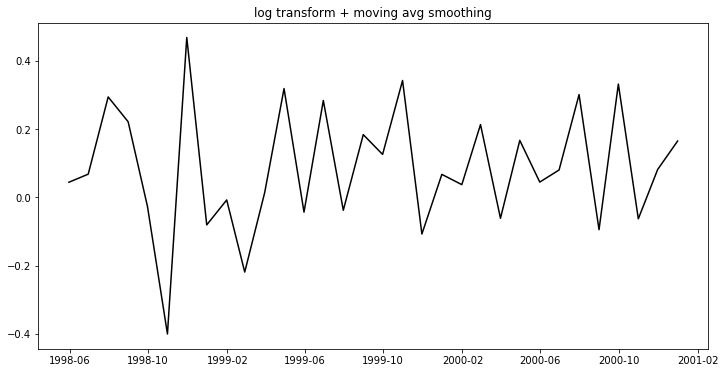

In [107]:
plt.figure(figsize=(12,6))
plt.plot(daterange, ts_log_moving_avg_diff, color='k')
plt.title('log transform + moving avg smoothing')
plt.show()

After the transformation, the time series data looks more stationary; i.e. by time there is no trend. To further confirm, we use the unit root test to examine the transformed data again:

In [108]:
print('Results of Dickey-Fuller Test:')
dftest = adfuller(ts_log_moving_avg_diff, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                 -2.923178
p-value                         0.042718
#Lags Used                     10.000000
Number of Observations Used    21.000000
Critical Value (1%)            -3.788386
Critical Value (10%)           -2.646397
Critical Value (5%)            -3.013098
dtype: float64


The p-value is now smaller than 0.05. Meanwhile, ACF and PACF plots show

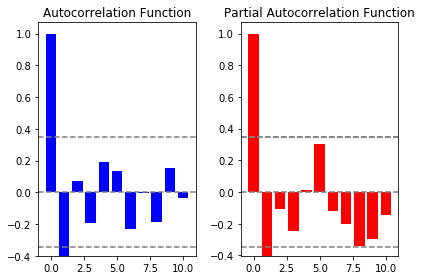

In [37]:
lag_acf = acf(ts_log_moving_avg_diff, nlags=10)
lag_pacf = pacf(ts_log_moving_avg_diff, nlags=10, method='ols')

#Plot ACF: 
plt.subplot(121) 
plt.bar(np.arange(11), lag_acf, color='blue')
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_moving_avg_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_moving_avg_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.bar(np.arange(11), lag_pacf, color='red')
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_moving_avg_diff)),linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_moving_avg_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_moving_avg_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

plt.show()

The autocorrelation show very significant dcay. Now let's train the ARIMA again with grid search

In [47]:
min_mse, min_aic, best_pdq = float('inf'), float('inf'), None
for p in range(6):
    for d in range(3):
        for q in range(3):
            try:
                mse, aic = evaluate_ARIMA_mse(ts_log_moving_avg_diff.tolist(), (p,d,q))
                print ((p, d, q), mse, aic)
                if aic < min_aic:
                    min_mse, min_aic, best_pdq = mse, aic, (p,d,q)
            except:
                continue

(0, 0, 0) 0.0205118799969 -13.1482616342
(0, 0, 1) 0.0126449429209 -17.290705641482887
(0, 0, 2) 0.0134879002996 -15.290954898528597
(0, 1, 0) 0.0704658467681 19.3080380984
(0, 1, 1) 0.021089251212 -6.3130801155689085
(0, 2, 0) 0.256074055423 54.7503818119
(0, 2, 1) 0.0748402580844 25.180536164400152
(1, 0, 0) 0.0127147028755 -16.45451570502523
(1, 0, 1) 0.0172734769436 -15.291039843858641
(1, 1, 0) 0.0263082882197 3.580201519758603
(1, 1, 1) 0.0130627196671 -8.973726795694319


/Users/hhhung/anaconda/lib/python3.4/site-packages/statsmodels/tsa/tsatools.py:562: RuntimeWarning: invalid value encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
/Users/hhhung/anaconda/lib/python3.4/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:649: RuntimeWarning: divide by zero encountered in true_divide
  R_mat, T_mat)
/Users/hhhung/anaconda/lib/python3.4/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/hhhung/anaconda/lib/python3.4/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/hhhung/anaconda/lib/python3.4/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Use

(1, 2, 0) 0.0722655204793 28.84640341866914
(2, 0, 0) 0.0129045229724 -14.714105319903169
(2, 0, 1) 0.0161558067174 -14.80732828392236
(2, 1, 0) 0.0211868948562 2.7161462923221364


/Users/hhhung/anaconda/lib/python3.4/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/hhhung/anaconda/lib/python3.4/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/hhhung/anaconda/lib/python3.4/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/hhhung/anaconda/lib/python3.4/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/hhhung/anaconda/lib/python3.4/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed

(2, 1, 1) 0.0130556338271 -7.149524975759107


/Users/hhhung/anaconda/lib/python3.4/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/hhhung/anaconda/lib/python3.4/site-packages/statsmodels/tsa/tsatools.py:536: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/hhhung/anaconda/lib/python3.4/site-packages/statsmodels/tsa/tsatools.py:536: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/hhhung/anaconda/lib/python3.4/site-packages/statsmodels/tsa/tsatools.py:537: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/hhhung/anaconda/lib/python3.4/site-packages/statsmodels/tsa/tsatools.py:537: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/

(2, 1, 2) 0.0133463163357 -6.409117739648025


/Users/hhhung/anaconda/lib/python3.4/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(2, 2, 0) 0.0464504883155 25.408779074101062
(3, 0, 0) 0.0148146496488 -14.84311283576649
(3, 0, 1) 0.0150681015829 -12.851770010298821
(3, 0, 2) 0.0125672722562 -16.81063168382188
(3, 1, 0) 0.0242978358457 -2.25947545479184


/Users/hhhung/anaconda/lib/python3.4/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/hhhung/anaconda/lib/python3.4/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/hhhung/anaconda/lib/python3.4/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/hhhung/anaconda/lib/python3.4/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/hhhung/anaconda/lib/python3.4/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed

(3, 1, 1) 0.0162534363143 -7.207923551060745
(3, 1, 2) 0.0161281024404 -11.074797613358427
(3, 2, 0) 0.0515890265694 21.66678913118305
(4, 0, 0) 0.0154222442429 -12.870122950894356
(4, 0, 1) 0.0154548662398 -11.092212386010331


/Users/hhhung/anaconda/lib/python3.4/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(4, 1, 0) 0.0161472923644 -7.635441879113586


/Users/hhhung/anaconda/lib/python3.4/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/hhhung/anaconda/lib/python3.4/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/hhhung/anaconda/lib/python3.4/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/hhhung/anaconda/lib/python3.4/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/hhhung/anaconda/lib/python3.4/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed

(4, 1, 1) 0.0168776971543 -5.651899643813266
(4, 1, 2) 0.0159199524992 -9.7823246516177


/Users/hhhung/anaconda/lib/python3.4/site-packages/statsmodels/regression/linear_model.py:925: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)
/Users/hhhung/anaconda/lib/python3.4/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/hhhung/anaconda/lib/python3.4/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/hhhung/anaconda/lib/python3.4/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/hhhung/anaconda/lib/python3.4/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Chec

(4, 2, 1) 0.0214728603586 2.1957231214179984


/Users/hhhung/anaconda/lib/python3.4/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/hhhung/anaconda/lib/python3.4/site-packages/statsmodels/tsa/tsatools.py:562: RuntimeWarning: divide by zero encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))


(5, 0, 0) 0.0133387990723 -13.101434316254483
(5, 0, 1) 0.0183905266341 -13.240509022100284


/Users/hhhung/anaconda/lib/python3.4/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/hhhung/anaconda/lib/python3.4/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/hhhung/anaconda/lib/python3.4/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/hhhung/anaconda/lib/python3.4/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(5, 0, 2) 0.012816060891 -8.408565499556332


/Users/hhhung/anaconda/lib/python3.4/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/hhhung/anaconda/lib/python3.4/site-packages/statsmodels/tsa/tsatools.py:520: RuntimeWarning: invalid value encountered in log
  invarcoefs = -np.log((1-params)/(1+params))
/Users/hhhung/anaconda/lib/python3.4/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/hhhung/anaconda/lib/python3.4/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/hhhung/anaconda/lib/python3.4/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "C

(5, 2, 1) 0.0204361592277 4.010997536916619


/Users/hhhung/anaconda/lib/python3.4/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [48]:
print (best_pdq, min_mse, min_aic)

(0, 0, 1) 0.0126449429209 -17.290705641482887


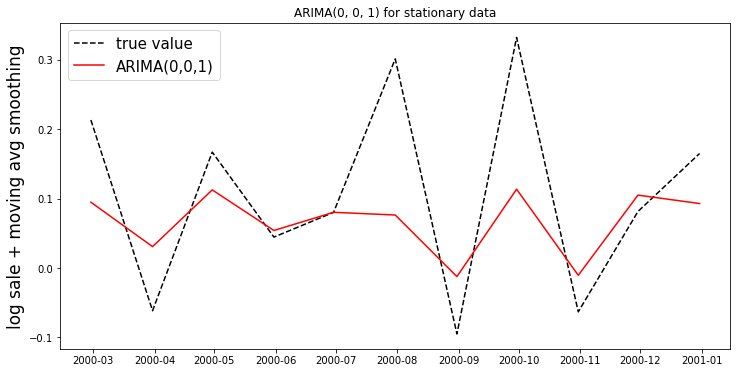

In [246]:
X = ts_log_moving_avg_diff.tolist()
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=best_pdq)
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))

plt.figure(figsize=(12,6))
plt.plot(daterange[size:len(X)], test, '--', color='k', label='true value')
plt.plot(daterange[size:len(X)], predictions, color='red', label ='ARIMA(0,0,1)')
plt.legend(loc='upper left', fontsize=15)
plt.title('ARIMA(0, 0, 1) for stationary data')
plt.ylabel('log sale + moving avg smoothing', fontsize=17)
plt.show()

In [229]:
model_fit = ARIMA(ts_log_moving_avg_diff.tolist(), order=best_pdq).fit(disp=-1)
forecast = model_fit.forecast(steps=3)[0]

In [230]:
len(ts_log_moving_avg_diff), len(train), len(test)

(32, 21, 11)

## Out-of-Sample Forecast

After we fit the ARIMA model, we have to recover back to the original scale; add the moving average back and take values exponentially. The out-of-sample forecast does not have `the moving average` however. Here we implement two simple ways to deal with. The first one is to add the latest moving average into the ARIMA forecast. The second is to add the fitted moving average using polynomial regression.

### Implement latest moving average


In [233]:
model_result = train+[x[0] for x in predictions]
moving_avg = moving_avg.dropna().tolist()
model_result = [model_result[i] + moving_avg[i] for i in range(len(moving_avg))]
model_result = [np.exp(x) for x in model_result]

In [234]:
forecast

array([ 0.05136667,  0.08357948,  0.08357948])

Simply add the latest moving average sale:

In [235]:
forecast1 = [np.exp(x + moving_avg[-1]) for x in forecast]

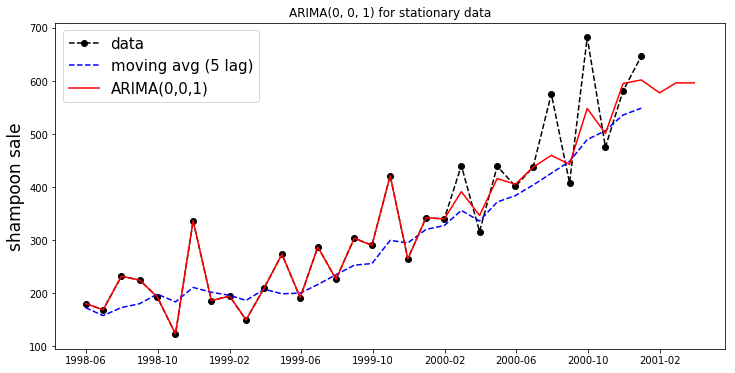

In [248]:
forecast_daterange = pd.date_range(dtte.datetime.strptime("1-May-1998", "%d-%b-%Y"), periods=35,freq='1M')

plt.figure(figsize=(12,6))
plt.plot(daterange, data['Sales of shampoo over a three year period'].iloc[4:], 'o--', color='k', label='data')
plt.plot(daterange, np.exp(moving_avg), '--', color='b', label='moving avg (5 lag)')
#plt.plot(daterange, AR_pred, '--', color='g', label='moving avg')
plt.plot(forecast_daterange, model_result+forecast1, color='red', label ='ARIMA(0,0,1)')
plt.legend(loc='upper left', fontsize=15)
plt.title('ARIMA(0, 0, 1) for stationary data')
plt.ylabel('shampoon sale', fontsize=17)
plt.show()

### Fit moving average using polynomial regression

Instead simply using the last month sale to offset the out-of-sample sale, we use scikit-learn's [polynomial regression](http://scikit-learn.org/stable/modules/linear_model.html#polynomial-regression-extending-linear-models-with-basis-functions) to forecast out-of-sample moving average, and then add the ARIMA forecast. 

In [238]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
import numpy as np
poly_linear_model = Pipeline([('poly', PolynomialFeatures(degree=2)), ('linear', LinearRegression(fit_intercept=False))])
x = np.arange(32)
poly_linear_model = poly_linear_model.fit(x[:, np.newaxis], moving_avg)
poly_linear_model.named_steps['linear'].coef_

array([  5.11911789e+00,   1.53637990e-02,   7.96425380e-04])

In [241]:
x2 = np.array([32,33,34])
poly_pred = poly_linear_model.predict(x2[:, np.newaxis])

In [242]:
forecast2 = [np.exp(forecast[i] + poly_pred[i]) for i in range(len(forecast))]

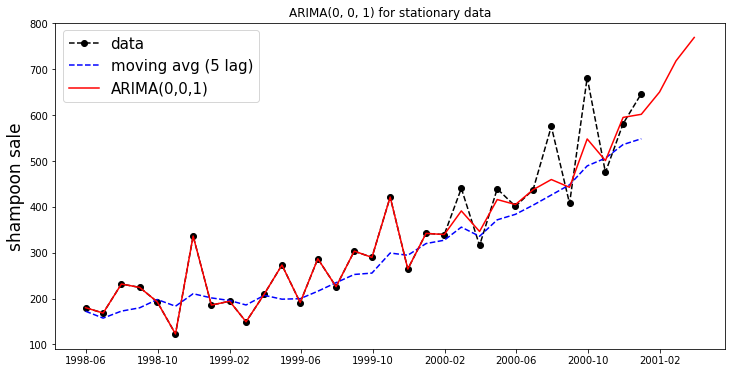

In [249]:
forecast_daterange = pd.date_range(dtte.datetime.strptime("1-May-1998", "%d-%b-%Y"), periods=35,freq='1M')

plt.figure(figsize=(12,6))
plt.plot(daterange, data['Sales of shampoo over a three year period'].iloc[4:], 'o--', color='k', label='data')
plt.plot(daterange, np.exp(moving_avg), '--', color='b', label='moving avg (5 lag)')
#plt.plot(daterange, AR_pred, '--', color='g', label='moving avg')
plt.plot(forecast_daterange, model_result+forecast2, color='red', label ='ARIMA(0,0,1)')
plt.legend(loc='upper left', fontsize=15)
plt.title('ARIMA(0, 0, 1) for stationary data')
plt.ylabel('shampoon sale', fontsize=17)
plt.show()

## Other Reference

[7 methods to perform Time Series forecasting (with Python codes)](https://www.analyticsvidhya.com/blog/2018/02/time-series-forecasting-methods/)